## Setup

In [191]:
## Libraries
# lightkurve
#import lightkurve as lk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
#import statsmodels.api as sm
# import itertools
import warnings
## Pyramid ARIMA
from pmdarima import auto_arima
import pickle

In [183]:
## Data
df = pd.read_csv("../0.Data/031381302.csv", index_col = "time")

# Check
print(df.shape)

## Time Series of interest
lightcurve = df.loc[:, ["pdcsap_flux"]]
lightcurve.sort_index(inplace=True)

# Check
print(lightcurve.shape); lightcurve.info(); lightcurve.head()

(17719, 23)
(17719, 1)
<class 'pandas.core.frame.DataFrame'>
Float64Index: 17719 entries, 1437.978645522663 to 1464.2854684532865
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pdcsap_flux  17033 non-null  float64
dtypes: float64(1)
memory usage: 276.9 KB


,pdcsap_flux
time,
1437.978646,NaN
1437.980034,NaN
1437.981423,NaN
1437.982812,NaN
1437.984201,NaN


# SARIMA Imputation

In [184]:
# ## BASE CODE ##
# 
# ## Time Differences (2-min cadence)
# time_diffs = lightcurve.index.to_series().diff()

# ## Setup
# lc_fill = lightcurve.copy()
# med = time_diffs.median()
# cur = 1

# ## Iteratively add indices where missing
# for k, id in enumerate(lightcurve.index):
#     if k == 0: continue
#     # print(k, id)
#     diff = time_diffs.iloc[k] #id - pdcsap["time"][k - 1]
#     diff_size = diff / med
#     if diff_size < 2:
#         pass
#     elif (diff_size >= 2) & (diff_size < 3):
#         newRows = pd.DataFrame({"pdcsap_flux": np.nan}, index = [id - med])
#         lc_fill = pd.concat([lc_fill, newRows])
#     else:
#         newInds = np.arange(start = lightcurve.index[k - 1] + med, stop = id - med, step = med)
#         newRows = pd.DataFrame({"pdcsap_flux": np.nan}, index = newInds)
#         lc_fill = pd.concat([lc_fill, newRows])

# ## Cleanup
# lc_fill.sort_index(inplace = True)

In [185]:
# ## ROUGH WORK ##
# lightcurve.columns[0]

# pd.DataFrame({lightcurve.columns[0]: np.nan}, index = [1])

In [186]:
def fill_times(series):
    ## Time Differences
    time_diffs = series.index.to_series().diff()

    ## Setup
    series_fill = series.copy()
    med = time_diffs.median()

    ## Iteration
    for k, id in enumerate(series.index):
        if k == 0: continue
        # print(k, id)
        diff = time_diffs.iloc[k] #id - pdcsap["time"][k - 1]
        diff_size = diff / med
        if diff_size < 2:
            pass
        elif (diff_size >= 2) & (diff_size < 3):
            new_rows = pd.DataFrame({series.columns[0]: np.nan}, index = [id - med])
            series_fill = pd.concat([series_fill, new_rows])
        else:
            new_inds = np.arange(start = series.index[k - 1] + med, stop = id - med, step = med)
            new_rows = pd.DataFrame({series.columns[0]: np.nan}, index = new_inds)
            series_fill = pd.concat([series_fill, new_rows])

    ## Cleanup
    series_fill.sort_index(inplace = True)

    return series_fill

(18856, 1)
<class 'pandas.core.frame.DataFrame'>
Float64Index: 18856 entries, 1437.978645522663 to 1464.2854684532865
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pdcsap_flux  17033 non-null  float64
dtypes: float64(1)
memory usage: 294.6 KB
None
Float64Index([ 1437.978645522663, 1437.9800344004182, 1437.9814232781732,
              1437.9828121559574, 1437.9842010337416],
             dtype='float64')
(1823,)


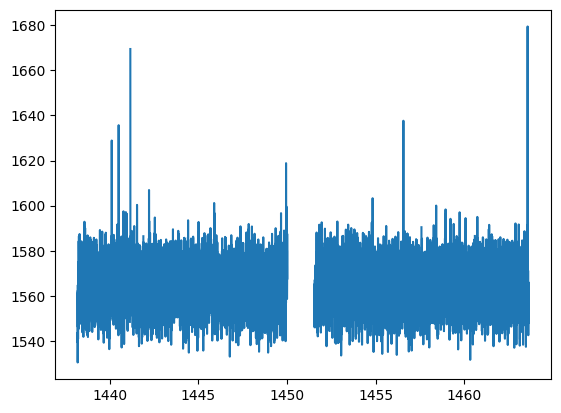

In [176]:
## TEMP ##
lc_fill = fill_times(lightcurve)
print(lc_fill.shape)
print(lc_fill.info())
plt.plot(lc_fill)

## Identify null_indices
null_indices = lc_fill.iloc[np.where(lc_fill.isna())[0]].index
print(null_indices[0:5])
print(null_indices.shape)

In [177]:
## Cut down
# lc_fill = lc_fill.iloc[0:1000]
# lc_fill = lc_fill.query("1447 <= index < 1453")
# lc_fill.shape

In [178]:
## LOG ##

## Run #2: lc_fill = lc_fill.query("1447 <= index < 1453")
# Best model:  ARIMA(4,0,4)(0,0,0)[5] intercept
# Total fit time: 1049.476 seconds
# Selected model order: (4, 0, 4) Seasonal order: (0, 0, 0, 5)

In [ ]:
## auto_arima
## Temp impute
lc_interp = lc_fill.fillna(lc_fill["pdcsap_flux"].mean())

## Suppress warnings for clean output
warnings.filterwarnings("ignore")

## Auto ARIMA
model_auto = auto_arima(
    lc_interp,
    start_p = 4, start_q = 4,
    start_P = 1, start_Q = 1,
    seasonal = True,
    m = 240,                    # Period (# of observations per cycle) based on EDA
    stepwise = True,
    trace = True,
    suppress_warnings = True,
    error_action = "ignore"
)

print("Selected model order:", model_auto.order, "Seasonal order:", model_auto.seasonal_order)

Performing stepwise search to minimize aic


C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,2)(1,0,1)[5] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "C:\Users\alexd\AppDat

 ARIMA(2,0,2)(1,0,1)[5] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[5] intercept   : AIC=30230.193, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[5] intercept   : AIC=inf, Time=3.38 sec
 ARIMA(0,0,1)(0,0,1)[5] intercept   : AIC=29689.244, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[5]             : AIC=75688.483, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[5] intercept   : AIC=29892.144, Time=0.43 sec
 ARIMA(0,0,1)(1,0,1)[5] intercept   : AIC=inf, Time=3.74 sec
 ARIMA(0,0,1)(0,0,2)[5] intercept   : AIC=29609.745, Time=1.20 sec
 ARIMA(0,0,1)(1,0,2)[5] intercept   : AIC=inf, Time=6.53 sec
 ARIMA(0,0,0)(0,0,2)[5] intercept   : AIC=29735.779, Time=1.16 sec
 ARIMA(1,0,1)(0,0,2)[5] intercept   : AIC=29336.061, Time=6.27 sec
 ARIMA(1,0,1)(0,0,1)[5] intercept   : AIC=29361.190, Time=2.49 sec


C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(1,0,1)(1,0,2)[5] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "C:\Users\alexd\AppDat

 ARIMA(1,0,1)(1,0,2)[5] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(1,0,1)[5] intercept   : AIC=inf, Time=6.05 sec
 ARIMA(1,0,0)(0,0,2)[5] intercept   : AIC=29589.488, Time=3.52 sec
 ARIMA(2,0,1)(0,0,2)[5] intercept   : AIC=29222.492, Time=6.63 sec
 ARIMA(2,0,1)(0,0,1)[5] intercept   : AIC=29234.387, Time=4.71 sec


C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,1)(1,0,2)[5] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "C:\Users\alexd\AppDat

 ARIMA(2,0,1)(1,0,2)[5] intercept   : AIC=inf, Time=nan sec
 ARIMA(2,0,1)(1,0,1)[5] intercept   : AIC=inf, Time=57.11 sec
 ARIMA(2,0,0)(0,0,2)[5] intercept   : AIC=29330.693, Time=4.33 sec
 ARIMA(3,0,1)(0,0,2)[5] intercept   : AIC=29167.601, Time=7.06 sec
 ARIMA(3,0,1)(0,0,1)[5] intercept   : AIC=29169.020, Time=3.83 sec


C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(3,0,1)(1,0,2)[5] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "C:\Users\alexd\AppDat

 ARIMA(3,0,1)(1,0,2)[5] intercept   : AIC=inf, Time=nan sec


C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(3,0,1)(1,0,1)[5] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "C:\Users\alexd\AppDat

 ARIMA(3,0,1)(1,0,1)[5] intercept   : AIC=inf, Time=nan sec
 ARIMA(3,0,0)(0,0,2)[5] intercept   : AIC=29198.028, Time=3.05 sec
 ARIMA(4,0,1)(0,0,2)[5] intercept   : AIC=29074.417, Time=4.36 sec
 ARIMA(4,0,1)(0,0,1)[5] intercept   : AIC=29061.738, Time=6.30 sec
 ARIMA(4,0,1)(0,0,0)[5] intercept   : AIC=29084.650, Time=0.57 sec


C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(4,0,1)(1,0,1)[5] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "C:\Users\alexd\AppDat

 ARIMA(4,0,1)(1,0,1)[5] intercept   : AIC=inf, Time=nan sec
 ARIMA(4,0,1)(1,0,0)[5] intercept   : AIC=inf, Time=7.18 sec


C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(4,0,1)(1,0,2)[5] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "C:\Users\alexd\AppDat

 ARIMA(4,0,1)(1,0,2)[5] intercept   : AIC=inf, Time=nan sec
 ARIMA(4,0,0)(0,0,1)[5] intercept   : AIC=29075.270, Time=2.10 sec
 ARIMA(4,0,2)(0,0,1)[5] intercept   : AIC=29027.203, Time=4.35 sec
 ARIMA(4,0,2)(0,0,0)[5] intercept   : AIC=29027.971, Time=2.68 sec
 ARIMA(4,0,2)(1,0,1)[5] intercept   : AIC=inf, Time=52.23 sec
 ARIMA(4,0,2)(0,0,2)[5] intercept   : AIC=29015.690, Time=5.60 sec


C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(4,0,2)(1,0,2)[5] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "C:\Users\alexd\AppDat

 ARIMA(4,0,2)(1,0,2)[5] intercept   : AIC=inf, Time=nan sec
 ARIMA(3,0,2)(0,0,2)[5] intercept   : AIC=29028.168, Time=8.77 sec
 ARIMA(4,0,3)(0,0,2)[5] intercept   : AIC=28942.480, Time=11.02 sec
 ARIMA(4,0,3)(0,0,1)[5] intercept   : AIC=28941.295, Time=8.37 sec
 ARIMA(4,0,3)(0,0,0)[5] intercept   : AIC=28941.852, Time=4.52 sec


C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(4,0,3)(1,0,1)[5] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "C:\Users\alexd\AppDat

 ARIMA(4,0,3)(1,0,1)[5] intercept   : AIC=inf, Time=nan sec
 ARIMA(4,0,3)(1,0,0)[5] intercept   : AIC=inf, Time=116.98 sec
 ARIMA(4,0,3)(1,0,2)[5] intercept   : AIC=inf, Time=35.03 sec
 ARIMA(3,0,3)(0,0,1)[5] intercept   : AIC=28966.808, Time=6.53 sec
 ARIMA(4,0,4)(0,0,1)[5] intercept   : AIC=28940.479, Time=8.79 sec
 ARIMA(4,0,4)(0,0,0)[5] intercept   : AIC=28934.554, Time=6.09 sec
 ARIMA(4,0,4)(1,0,0)[5] intercept   : AIC=inf, Time=8.42 sec
 ARIMA(4,0,4)(1,0,1)[5] intercept   : AIC=inf, Time=273.71 sec
 ARIMA(3,0,4)(0,0,0)[5] intercept   : AIC=28951.512, Time=4.82 sec
 ARIMA(3,0,3)(0,0,0)[5] intercept   : AIC=28953.159, Time=4.28 sec
 ARIMA(4,0,4)(0,0,0)[5]             : AIC=28961.800, Time=2.82 sec

Best model:  ARIMA(4,0,4)(0,0,0)[5] intercept
Total fit time: 1049.476 seconds
Selected model order: (4, 0, 4) Seasonal order: (0, 0, 0, 5)


In [146]:
# ## BASE CODE ##
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# model = SARIMAX(
#     lc_fill,
#     order = (1, 0, 1),
#     seasonal_order = (1, 1, 1, 240),
#     enforce_stationarity = False,
#     enforce_invertibility = False
# )

In [147]:
# results = model_auto.fit()

# print(results.summary())

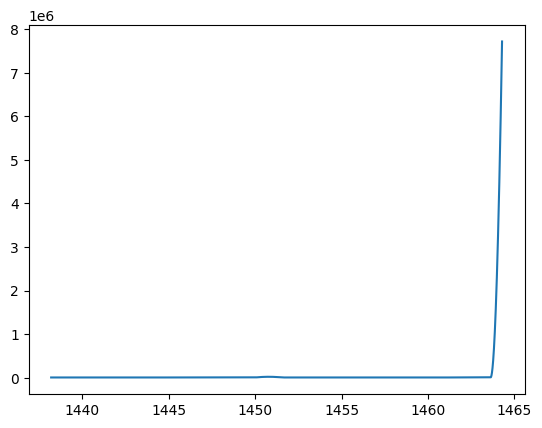

In [ ]:
## ROUGH WORK ##
# lc_interp = lc_fill.interpolate(method = "spline", order = 2)
# lc_interp.info()
# lc_interp.describe()
# plt.plot(lc_interp)

In [ ]:
# def sarima_impute():
#     ## 

#     return 1

In [141]:
d = model_auto.order[1]
pred_vals = model_auto.predict_in_sample(start = d, end = lc_fill.shape[0] - 1)
lc_fill.loc[null_indices[np.isin(null_indices, lc_fill.index[d:])], "pdcsap_flux"] = pred_vals[np.isin(lc_fill.index[d:], null_indices)] 

In [ ]:
## Check
lc_fill.shape
print(lc_fill.describe())
lc_fill.info()
print(lc_fill.index.max())

       pdcsap_flux
count  4313.000000
mean   1564.443354
std       8.051694
min    1534.878300
25%    1560.275300
50%    1564.441003
75%    1568.530500
max    1618.817300
<class 'pandas.core.frame.DataFrame'>
Float64Index: 4313 entries, 1447.000823172425 to 1452.9993977335207
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pdcsap_flux  4313 non-null   float64
dtypes: float64(1)
memory usage: 196.4 KB
1452.9993977335207
<class 'pandas.core.series.Series'>
Float64Index: 4313 entries, 1447.000823172425 to 1452.9993977335207
Series name: predicted_mean
Non-Null Count  Dtype  
--------------  -----  
4313 non-null   float64
dtypes: float64(1)
memory usage: 67.4 KB


1823

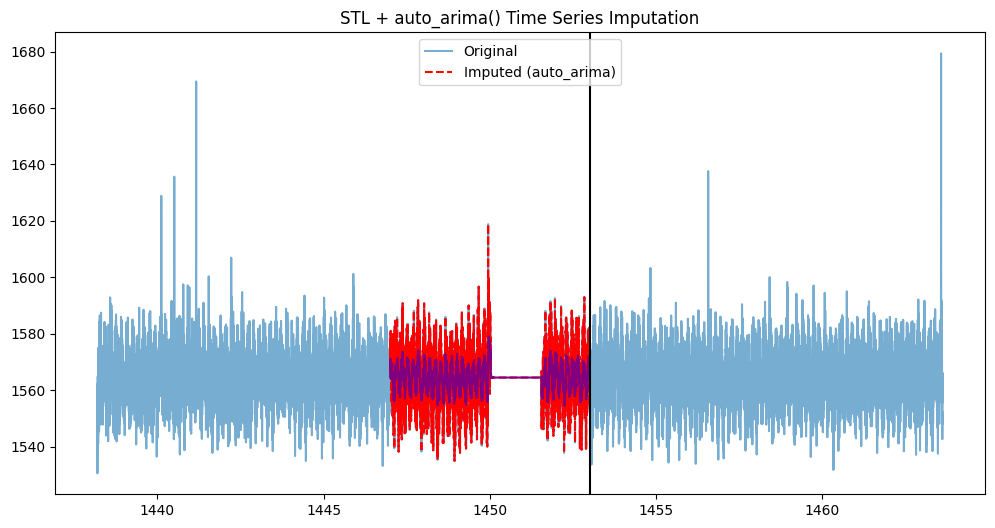

In [145]:
## Check
# Plot original vs imputed series
plt.figure(figsize=(12,6))
plt.plot(lightcurve, label='Original', alpha=0.6)
plt.plot(lc_fill, label='Imputed (auto_arima)', linestyle='--', color='red')
plt.plot(pd.Series(pred_vals, index = lc_fill.index), color = "purple")
plt.axvline(lc_fill.index.max(), color = "black")
plt.title("STL + auto_arima() Time Series Imputation")
plt.legend()
plt.show()

In [192]:
## Save model
filename = "sarima_model.sav"
pickle.dump(model_auto, open(filename, 'wb'))

# ## Open model
# loaded_model = pickle.load(open(filename, 'rb'))

# STL Decomposition

(18856, 1)
<class 'pandas.core.frame.DataFrame'>
Float64Index: 18856 entries, 1437.978645522663 to 1464.2854684532865
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pdcsap_flux  17033 non-null  float64
dtypes: float64(1)
memory usage: 294.6 KB
None


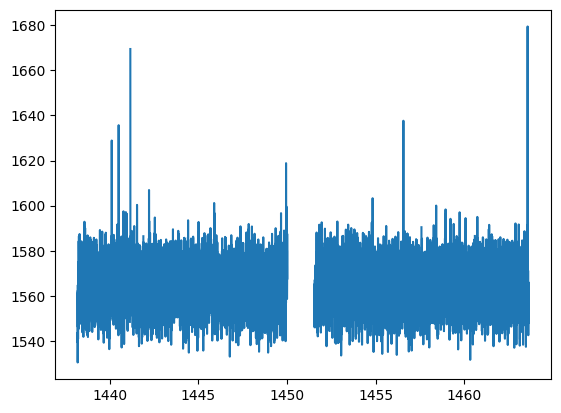

In [194]:
## TEMP ##
lc_fill = fill_times(lightcurve)
print(lc_fill.shape)
print(lc_fill.info())
plt.plot(lc_fill)

lc_interp = lc_fill.fillna(lc_fill["pdcsap_flux"].mean())

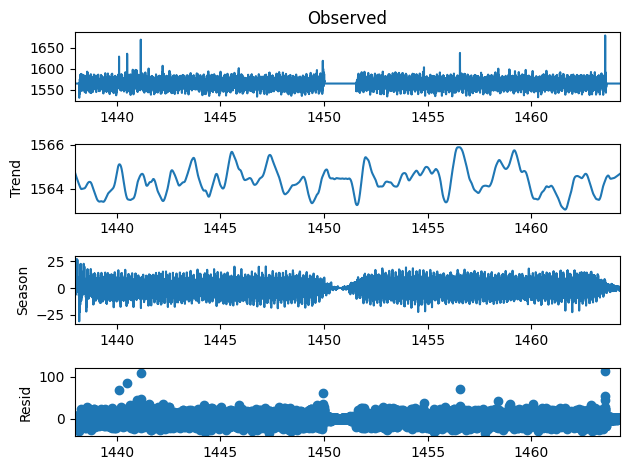

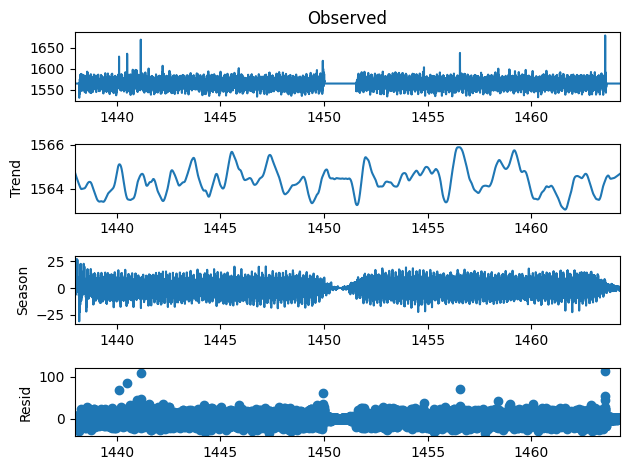

In [195]:
## STL Decomposition
stl = STL(lc_interp, period=240, robust=True)  # Use period=240 based on EDA
decomposition = stl.fit()

# Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

## Plot
decomposition.plot()

In [196]:
# Check
residual.info(); residual.head(); residual.describe()

<class 'pandas.core.series.Series'>
Float64Index: 18856 entries, 1437.978645522663 to 1464.2854684532865
Series name: resid
Non-Null Count  Dtype  
--------------  -----  
18856 non-null  float64
dtypes: float64(1)
memory usage: 294.6 KB


count    18856.000000
mean         0.106673
std          6.714784
min        -34.267261
25%         -2.966608
50%          0.001416
75%          3.065438
max        113.875131
Name: resid, dtype: float64

In [197]:
## Save the imputed dataset
lc_fill["pdcsap_clean"] = residual #pdcsap_imputed
lc_fill["trend"] = trend
lc_fill["seasonal"] = seasonal
lc_fill.to_csv("../0.Data/031381302_imputed.csv")

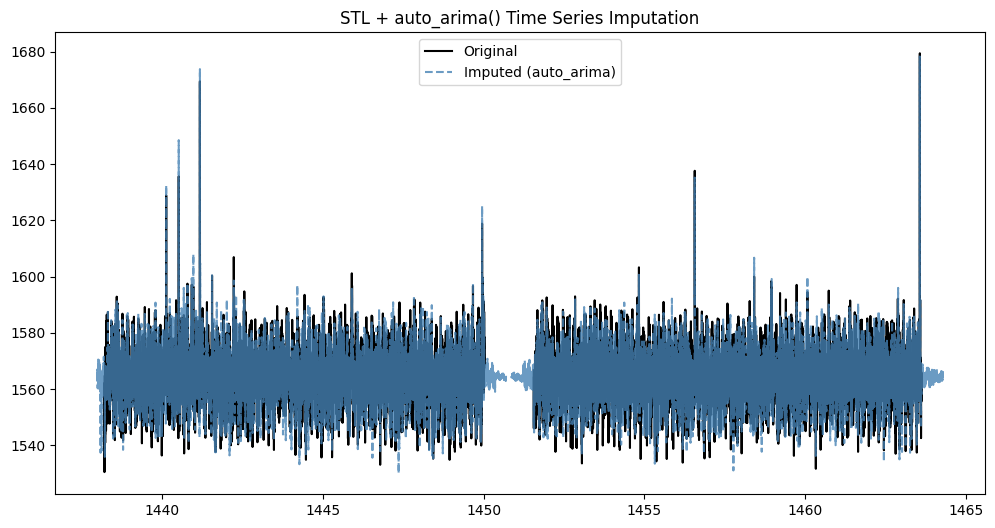

In [210]:
## Check
# Plot original vs imputed series
plt.figure(figsize=(12,6))
plt.plot(lightcurve, label='Original', color = "black")
plt.plot(lc_fill["pdcsap_clean"] + trend.mean(), label='Imputed (auto_arima)', linestyle='--', color = "steelblue", alpha = 0.8)
plt.title("STL + auto_arima() Time Series Imputation")
plt.legend()
plt.show()